# deepctr

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
from copy import deepcopy
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from hyperopt import hp
from deepctr.models import xDeepFM
from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, LE, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
ecd = LE(feature_col, bin_col=bin_col, class_col=class_col)

ecd.fit(train_df, verbose=1)
ecd.fit(test_df, verbose=1)

x_train_arr = ecd.transform(train_df, verbose=1)
x_test_arr = ecd.transform(test_df, verbose=1)

del train_df, test_df

600000it [00:09, 60859.78it/s]
400000it [00:06, 59602.17it/s]
600000it [00:10, 58626.56it/s]
400000it [00:06, 57245.79it/s]


In [5]:
# x_train_df = pd.DataFrame(data=x_train_arr, columns=feature_col)
# x_test_df = pd.DataFrame(data=x_test_arr, columns=feature_col)

In [6]:
def col_func(vocabulary, sparse_features, dense_features, k=5):
    # sparse
    feature_col = list()
    for f in sparse_features:
        feature_col.append(SparseFeat(f, vocabulary_size=vocabulary[f], embedding_dim=k))
    for f in dense_features:
        feature_col.append(DenseFeat(f, 1))

    dnn_f = feature_col
    linear_f= feature_col
    fn = get_feature_names(linear_f + dnn_f)
    return dnn_f, linear_f, fn

In [7]:
def xdeepfm(vocabulary, k, loss, metrics, optimizer, 
            num_deep_layer=2, num_neuron=256,
            num_cin_layer=2, num_cin=128,**kwargs):
    
    dnn_f, linear_f, _ = col_func(vocabulary, sparse_features=class_col, dense_features=bin_col, k=k)
    tf.random.set_seed(1024)
    model = xDeepFM(linear_feature_columns=linear_f,
                    dnn_feature_columns=dnn_f, 
                    cin_layer_size=tuple(num_cin for _ in range(num_cin_layer)),
                    dnn_hidden_units=tuple(num_neuron for _ in range(num_deep_layer)),
                    **kwargs)
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [8]:
def mkinput(input_arr, feature_col):
    return dict(zip(feature_col, input_arr.T))

# Search Max LR

In [9]:
%%time
%matplotlib inline

batch_size = 8192
epochs = 5
nflold = 5

model_param = {}

mf = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=len(x_train_arr)*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = xdeepfm(vocabulary=ecd.get_vocabulary(),
                k=10,
                loss='binary_crossentropy',
                metrics=['AUC'], 
                optimizer='Adam')

cv = CV(model, nflold)

score = cv.fit(x=mkinput(x_train_arr, feature_col),
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size': batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 15s 31us/sample - loss: 0.8805 - AUC: 0.4987 - val_loss: 0.7894 - val_AUC: 0.5021
Epoch 2/5
479999/479999 [==============================] - 7s 14us/sample - loss: 0.6076 - AUC: 0.5007 - val_loss: 0.4845 - val_AUC: 0.6621
Epoch 3/5
479999/479999 [==============================] - 7s 14us/sample - loss: 0.4366 - AUC: 0.7251 - val_loss: 0.4011 - val_AUC: 0.7818
Epoch 4/5
479999/479999 [==============================] - 7s 14us/sample - loss: 0.4039 - AUC: 0.7800 - val_loss: 0.4196 - val_AUC: 0.7812
Epoch 5/5
479999/479999 [==============================] - 6s 14us/sample - loss: 1.2881 - AUC: 0.5980 - val_loss: 3.0844 - val_AUC: 0.5000
folds 0 is done, score is 0.5
Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 12s 26us/sample - loss: 0.7991 - AUC: 0.4980 - val_loss: 0.6076 - val_AUC: 0.5007
Epoch 2/5
479999/479999 

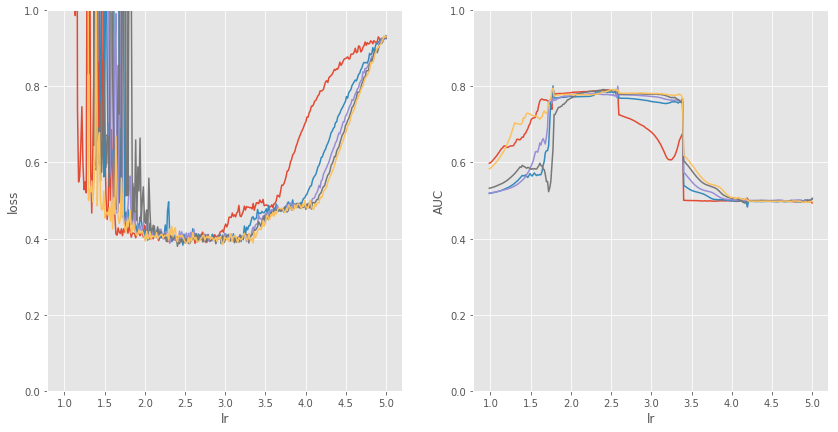

In [10]:
%matplotlib inline
mf.plot(True, [0, 1])

# fit one

In [13]:
def cv_score(batch_size, epochs, nflod, base_lr, max_lr, model_params, model_func, verbose=1):
    clr = CyclicLR(base_lr=0.1**(base_lr),
                   max_lr = 0.1**(max_lr), 
                   step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
                   mode='triangular2',
                   gamma=1.0)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=2, mode='max', restore_best_weights=True)

    fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': verbose, 'callbacks':[es, clr]}

    model = model_func(**model_params)

    cv = CV(model, nflod, random_state=2333)

    score = cv.fit(x=mkinput(x_train_arr, feature_col),
                   y=y_train,
                   metrics_func=roc_auc_score,
                   split_method=StratifiedKFold,
                   fit_params=fit_param,
                   eval_param={'batch_size':batch_size},
                   use_proba=False, 
                   verbose=verbose,
                   fit_use_valid=True)

    tf.keras.backend.clear_session()
    print(score)

In [10]:
%%time

model_params = {'vocabulary': ecd.get_vocabulary(),
                'loss': 'binary_crossentropy',
                'metrics': ['AUC'], 
                'optimizer': 'Adam',
                'num_deep_layer': 2, 
                'num_neuron': 256,
                'dnn_activation': 'relu', 
                'dnn_use_bn': False,  
                'k': 20,
                'num_cin_layer': 3,
                'num_cin': 200,
                'seed': 2333}


cv_score(batch_size=8192, 
         epochs=100, 
         nflod=5, 
         base_lr=4.5,
         max_lr=3.5,
         model_params=model_params,
         model_func=xdeepfm,
         verbose=1)

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 24s 50us/sample - loss: 0.3892 - AUC: 0.7997 - val_loss: 0.3997 - val_AUC: 0.7842
folds 0 is done, score is 0.7850282263679488
Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 30s 62us/sample - loss: 0.5996 - AUC: 0.5020 - val_loss: 0.4908 - val_AUC: 0.5537
Epoch 2/100
479999/479999 [==============================] - 25s 51us/sample - loss: 0.4772 - AUC: 0.6654 - val_loss: 0.4488 - val_AUC: 0.7586
Epoch 3/100
479999/479999 [==============================] - 25s 51us/sample - loss: 0.4086 - AUC: 0.7756 - val_loss: 0.3977 - val_AUC: 0.7890
Epoch 4/100
479999/479999 [==============================] - 25s 52us/sample - loss: 0.3926 - AUC: 0.7953 - val_loss: 0.3966 - val_AUC: 0.7889
Epoch 5/100
479999/479999 [==============================] - 25s 51us/sample - loss: 0.3905 - AUC: 0.7973 - val_loss: 0.3967 - val_AUC: 

# tunning

In [9]:
batch_size = 8192
epochs = 100
nflod = 5
seed = 2333

# fit param

clr = CyclicLR(base_lr=0.1**(4.5),
               max_lr = 0.1**(3.5),
               step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary': ecd.get_vocabulary(),
                   'loss': 'binary_crossentropy',
                   'metrics': ['AUC'], 
                   'optimizer': 'Adam',
                   'dnn_activation': 'relu', 
                   'dnn_use_bn': False, 
                   'num_deep_layer': 2, 
                   'num_neuron': 256}

ss = {
    'k': (hp.choice, (5, 10, 20)),
    'num_cin_layer': (hp.choice, (1, 2, 3)),
    'num_cin': (hp.choice, (20, 40, 100, 200)),
    'l2_reg_linear': (hp.loguniform, (-20, 0)),
    'l2_reg_embedding': (hp.loguniform, (-20, 0)),
    'l2_reg_dnn': (hp.loguniform, (-20, 0)),
    'l2_reg_cin': (hp.loguniform, (-20, 0)),
    'dnn_dropout': (hp.uniform, (0, 0.5))
}


# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=mkinput(x_train_arr, feature_col),
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=seed,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7874, param {'dnn_dropout': 0.3644291199924518, 'k': 5, 'l2_reg_cin': 0.00022470479185888914, 'l2_reg_dnn': 3.7380537444793515e-07, 'l2_reg_embedding': 4.289008229170051e-05, 'l2_reg_linear': 1.104053050486251e-08, 'num_cin': 100, 'num_cin_layer': 1}
new best, eval 2, score -0.7874, param {'dnn_dropout': 0.3327502670855964, 'k': 5, 'l2_reg_cin': 0.006964933530795498, 'l2_reg_dnn': 1.9090037420888047e-08, 'l2_reg_embedding': 2.0052795687468222e-05, 'l2_reg_linear': 0.011550286575329359, 'num_cin': 200, 'num_cin_layer': 3}
new best, eval 6, score -0.7881, param {'dnn_dropout': 0.21438676246984728, 'k': 5, 'l2_reg_cin': 0.00034957359323283167, 'l2_reg_dnn': 2.5282345486120528e-08, 'l2_reg_embedding': 0.07251748366616431, 'l2_reg_linear': 0.00031108132901115144, 'num_cin': 200, 'num_cin_layer': 1}
new best, eval 17, score -0.7886, param {'dnn_dropout': 0.05777984859301, 'k': 10, 'l2_reg_cin': 0.0011982791378425488, 'l2_reg_dnn': 5.662165111975889e-09, 'l2_reg_emb

{'dnn_dropout': 0.18611304379017712,
 'k': 0,
 'l2_reg_cin': 0.0007457998620828029,
 'l2_reg_dnn': 1.8742851774431286e-05,
 'l2_reg_embedding': 0.018499683488742747,
 'l2_reg_linear': 8.074935191360416e-05,
 'num_cin': 2,
 'num_cin_layer': 1}

In [11]:
log = tuning.log.get_log()

In [12]:
log.sort_values('score').head()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear,num_cin,num_cin_layer
92,-0.788755,True,272.191713,0.186113,5,0.000746,1.874285e-05,0.018500,8.074935e-05,100,2
76,-0.788704,True,232.292037,0.091896,5,0.020388,2.486737e-07,0.027947,2.004206e-03,20,2
31,-0.788699,True,224.581600,0.020005,10,0.035603,8.096077e-08,0.024884,5.044019e-09,40,1
77,-0.788696,False,213.887601,0.062529,5,0.575998,2.831794e-06,0.028971,1.880758e-03,20,2
82,-0.788684,False,209.731294,0.001389,5,0.026556,1.129387e-06,0.031620,4.039779e-02,20,2


In [13]:
log.sort_values('score').tail()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear,num_cin,num_cin_layer
47,-0.766616,False,961.034615,0.357167,10,1.066004e-07,4.388497e-03,2.970766e-03,5.378808e-05,100,2
61,-0.764763,False,3844.076238,0.045472,20,1.790594e-08,5.971969e-04,2.129057e-02,5.277080e-08,100,3
26,-0.749264,False,1993.043875,0.224683,10,1.131940e-01,1.184936e-07,1.189638e-02,1.569744e-04,200,2
15,-0.734270,False,2593.899451,0.049537,20,3.454842e-06,2.573692e-08,9.808664e-02,1.449304e-06,20,3
4,-0.714777,False,2905.751548,0.156598,20,1.079582e-04,2.157526e-07,3.162218e-07,2.401381e-05,200,3


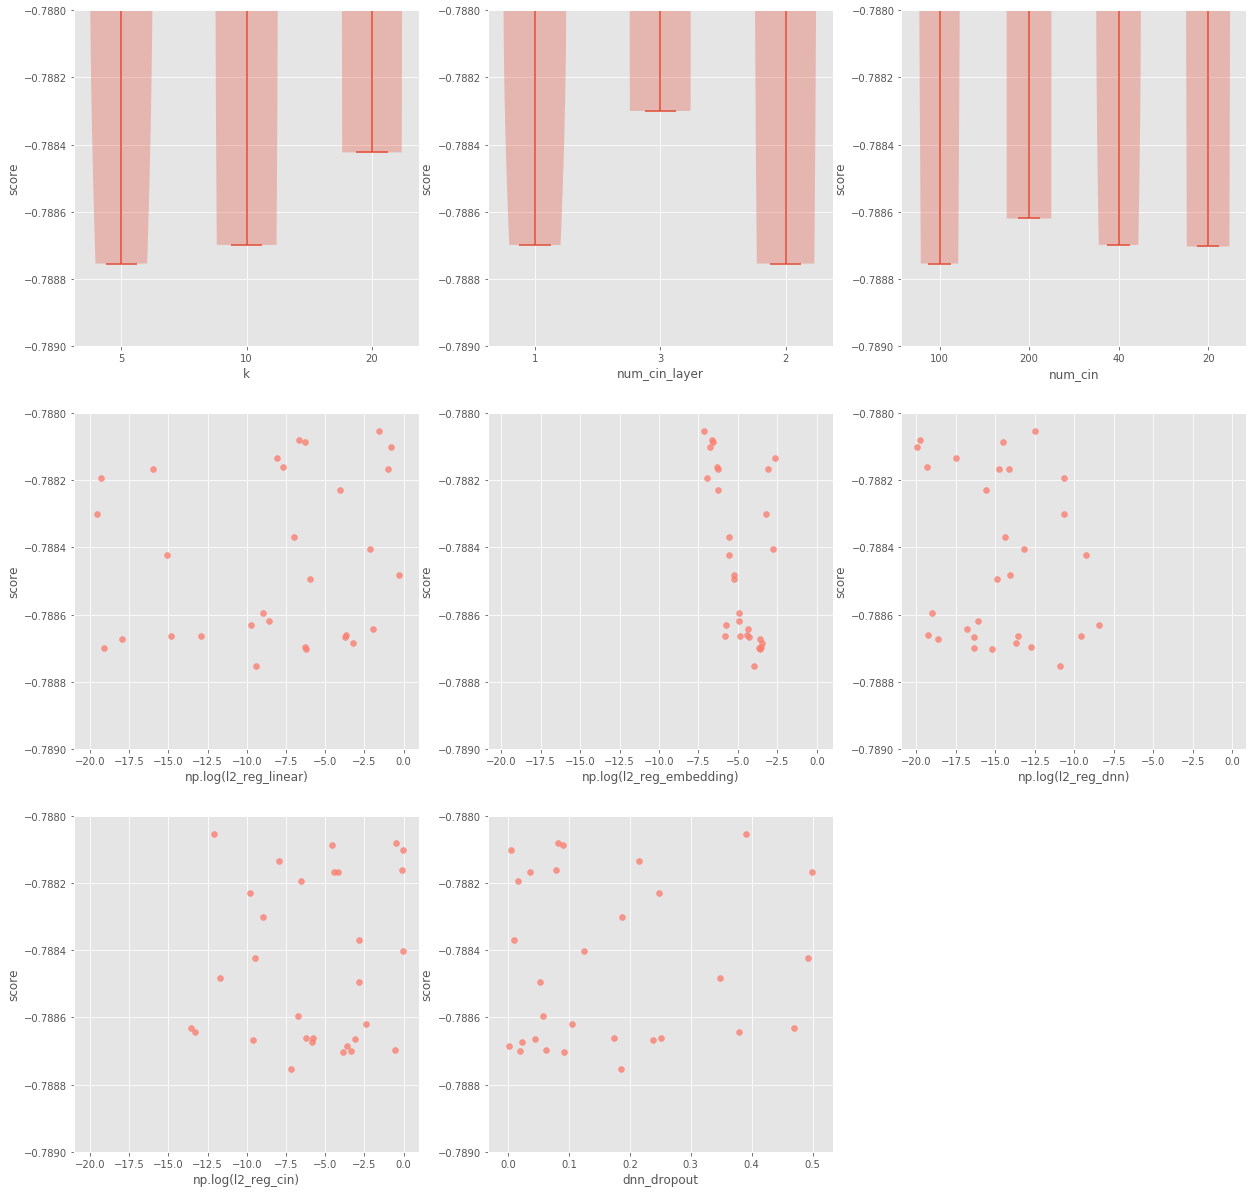

In [14]:
tuning.log.plot(score_interval=[-0.789, -0.788])

In [15]:
seed = np.random.randint(2**32)
print(seed)

3355867947


##  3355867947

In [16]:
######
log.to_csv(f'/data/{seed}.csv', index=False)
#####

In [9]:
######
seed = 3355867947
log = pd.read_csv(f'/data/{seed}.csv')
#####

# Try some new

In [10]:
# take bset
model_param = {'vocabulary': ecd.get_vocabulary(),
               'loss': 'binary_crossentropy',
               'metrics': ['AUC'], 
               'optimizer': 'Adam',
               'dnn_activation': 'relu', 
               'dnn_use_bn': False, 
               'num_deep_layer': 2, 
               'num_neuron': 256}

for col, val in log.sort_values('score').head(1).reset_index(drop=True).to_dict().items():
    if col not in ['score', 'update', 'usetime', 'index']:
        model_param[col] = val[0]

In [15]:
cv_score(batch_size=8192, 
         epochs=100, 
         nflod=5, 
         base_lr=4.5,
         max_lr=3.5,
         model_params=model_param,
         model_func=xdeepfm,
         verbose=1)

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 12s 24us/sample - loss: 0.8376 - AUC: 0.4987 - val_loss: 0.6898 - val_AUC: 0.4987
Epoch 2/100
479999/479999 [==============================] - 4s 7us/sample - loss: 0.5558 - AUC: 0.5038 - val_loss: 0.4927 - val_AUC: 0.6159
Epoch 3/100
479999/479999 [==============================] - 4s 7us/sample - loss: 0.4840 - AUC: 0.6440 - val_loss: 0.4689 - val_AUC: 0.7458
Epoch 4/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.4442 - AUC: 0.7435 - val_loss: 0.4257 - val_AUC: 0.7697
Epoch 5/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.4214 - AUC: 0.7755 - val_loss: 0.4181 - val_AUC: 0.7796
Epoch 6/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.4162 - AUC: 0.7817 - val_loss: 0.4150 - val_AUC: 0.7830
Epoch 7/100
479999/479999 [==============================] - 4s 7us/sample - loss: 0.4129 - AUC: 0.7

Epoch 7/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4081 - AUC: 0.7878 - val_loss: 0.4055 - val_AUC: 0.7914
Epoch 8/100
480001/480001 [==============================] - 4s 7us/sample - loss: 0.4056 - AUC: 0.7909 - val_loss: 0.4050 - val_AUC: 0.7919
Epoch 9/100
480001/480001 [==============================] - 3s 7us/sample - loss: 0.4046 - AUC: 0.7922 - val_loss: 0.4047 - val_AUC: 0.7921
Epoch 10/100
480001/480001 [==============================] - 4s 7us/sample - loss: 0.4049 - AUC: 0.7915 - val_loss: 0.4045 - val_AUC: 0.7922
Epoch 11/100
480001/480001 [==============================] - 4s 7us/sample - loss: 0.4052 - AUC: 0.7909 - val_loss: 0.4044 - val_AUC: 0.7920
Epoch 12/100
480001/480001 [==============================] - 4s 7us/sample - loss: 0.4055 - AUC: 0.7901 - val_loss: 0.4045 - val_AUC: 0.7915
folds 4 is done, score is 0.7922900156595112
0.7887547270571167


In [16]:
model_param['cin_activation'] = 'linear'
# model_param['dnn_activation']

cv_score(batch_size=8192, 
         epochs=100, 
         nflod=5, 
         base_lr=4.5,
         max_lr=3.5,
         model_params=model_param,
         model_func=xdeepfm,
         verbose=1)

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 10s 21us/sample - loss: 0.8196 - AUC: 0.4986 - val_loss: 0.6554 - val_AUC: 0.4987
Epoch 2/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.5382 - AUC: 0.5056 - val_loss: 0.4912 - val_AUC: 0.6287
Epoch 3/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4819 - AUC: 0.6617 - val_loss: 0.4643 - val_AUC: 0.7458
Epoch 4/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4394 - AUC: 0.7487 - val_loss: 0.4239 - val_AUC: 0.7725
Epoch 5/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4200 - AUC: 0.7773 - val_loss: 0.4178 - val_AUC: 0.7796
Epoch 6/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4156 - AUC: 0.7825 - val_loss: 0.4151 - val_AUC: 0.7827
Epoch 7/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4124 - AUC: 0.7

Epoch 7/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4070 - AUC: 0.7893 - val_loss: 0.4053 - val_AUC: 0.7916
Epoch 8/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4047 - AUC: 0.7921 - val_loss: 0.4048 - val_AUC: 0.7920
Epoch 9/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4037 - AUC: 0.7933 - val_loss: 0.4046 - val_AUC: 0.7921
Epoch 10/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4040 - AUC: 0.7927 - val_loss: 0.4044 - val_AUC: 0.7923
Epoch 11/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4042 - AUC: 0.7921 - val_loss: 0.4042 - val_AUC: 0.7921
Epoch 12/100
480001/480001 [==============================] - 4s 8us/sample - loss: 0.4045 - AUC: 0.7914 - val_loss: 0.4042 - val_AUC: 0.7917
folds 4 is done, score is 0.7923146561676961
0.7887860854076731


In [17]:
model_param['cin_activation'] = 'linear'
model_param['dnn_activation'] = 'mish'

cv_score(batch_size=8192, 
         epochs=100, 
         nflod=5, 
         base_lr=4.5,
         max_lr=3.5,
         model_params=model_param,
         model_func=xdeepfm,
         verbose=0)

0.7887118581850802


In [19]:
model_param['cin_activation'] = 'linear'
model_param['dnn_activation'] = 'relu'

cv_score(batch_size=8192, 
         epochs=100, 
         nflod=5, 
         base_lr=4.5,
         max_lr=3.5,
         model_params=model_param,
         model_func=xdeepfm,
         verbose=0)

0.7887807207782234


In [20]:
model_param['cin_activation'] = 'linear'
model_param['loss'] = 'focal_loss'

cv_score(batch_size=8192, 
         epochs=100, 
         nflod=5, 
         base_lr=4.5,
         max_lr=3.5,
         model_params=model_param,
         model_func=xdeepfm,
         verbose=0)

0.78197068222443


# stacking

In [ ]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 1

# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_param = {'vocabulary': ecd.get_vocabulary(),
               'loss': 'binary_crossentropy',
               'metrics': ['AUC'], 
               'optimizer': 'Adam',
               'dnn_activation': 'relu', 
               'dnn_use_bn': False, 
               'num_deep_layer': 2, 
               'num_neuron': 256, 
               'cin_activation': 'linear'}

# callbacks
clr = CyclicLR(
    base_lr=0.1**(5),
    max_lr = 0.1**(4), 
    step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = deepcopy(model_param)
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = xdeepfm(**model_params)
    cv = CV(model, nflod, random_state=2333)
    
    score, pred_arr = cv.fit(x=mkinput(x_train_arr, feature_col),
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=mkinput(x_test_arr, feature_col), pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    del model, cv
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.7866071040637098
folds 1 is done, score is 0.7868594595175424
folds 2 is done, score is 0.7842493872806661
folds 3 is done, score is 0.7932462572954289
folds 4 is done, score is 0.7870022044019337
folds 5 is done, score is 0.7898420353872699
folds 6 is done, score is 0.7814675104547563
folds 7 is done, score is 0.7965717150941068
folds 8 is done, score is 0.7838023631628044
folds 9 is done, score is 0.7854584541448879
folds 10 is done, score is 0.7903527679866673
folds 11 is done, score is 0.7845968539456072
folds 12 is done, score is 0.7852504368611242
folds 13 is done, score is 0.7927570084722316
folds 14 is done, score is 0.7950917443412522
folds 15 is done, score is 0.7933472938445462
folds 16 is done, score is 0.795831612878652
folds 17 is done, score is 0.7902969919558666
folds 18 is done, score is 0.7863127957195788
folds 19 is done, score is 0.7886710600477824
folds 20 is done, score is 0.785417107733996
folds 21 is done, score is 0.7871008749607421
